# Import bibliotek oraz wczytanie danych

In [226]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import scipy.sparse as sp
from libreco.data import random_split, DatasetPure, split_by_ratio_chrono
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate

In [227]:
df = pd.read_csv("C:\\Users\\marci\\OneDrive\\Pulpit\\archive\\interactions.csv",
                 #"C:\\Users\\fpazi\\Desktop\\projekty\\olx\\interactions.csv",
                 sep=',')

## Basic statistics

In [228]:
df['event'].value_counts()

event
click                    58817263
contact_phone_click_1     1721338
bookmark                  1644602
chat_click                1399051
contact_chat               948470
contact_partner_click      459305
contact_phone_click_2      444497
contact_phone_click_3       67675
Name: count, dtype: int64

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [230]:
n_users = df['user'].nunique()
n_items = df['item'].nunique()

print('Number of users: ', n_users)
print('Number of items: ', n_items)

Number of users:  3295942
Number of items:  185395


In [231]:
n_events_per_user = df.groupby('user').size()
n_events_per_item = df.groupby('item').size()

print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))

Average number of events per user:  19.87  with a standard deviation of  47.762363188402105
Average number of events per item:  353.31  with a standard deviation of  624.7732106025969


In [232]:
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))

Median number of events per user:  6.0
Median number of events per item:  137.0


## Number of interactions per user

In [233]:
n_events_per_user.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
dtype: float64

<Axes: ylabel='Proportion'>

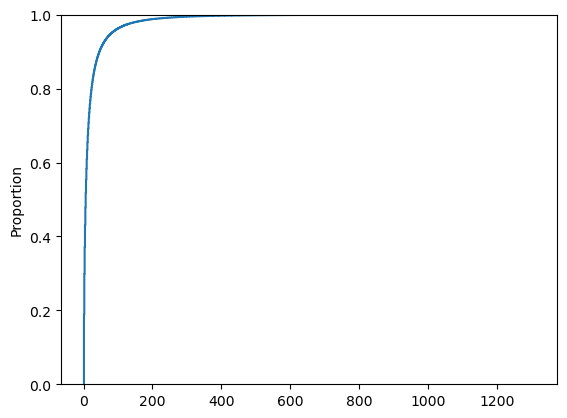

In [234]:
sns.ecdfplot(n_events_per_user)

<Axes: ylabel='Count'>

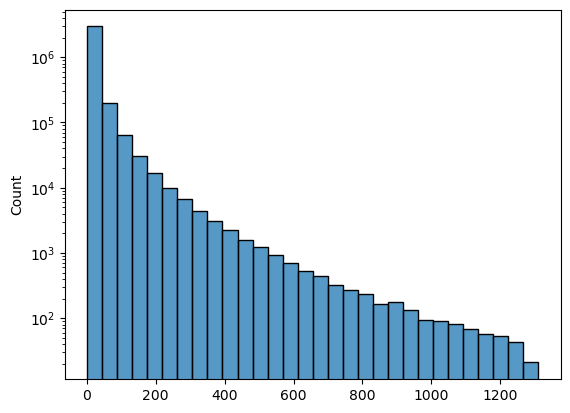

In [235]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1

<Axes: >

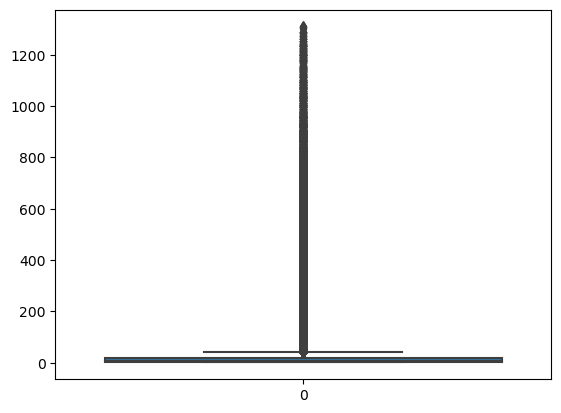

In [236]:
sns.boxplot(n_events_per_user)

<Axes: >

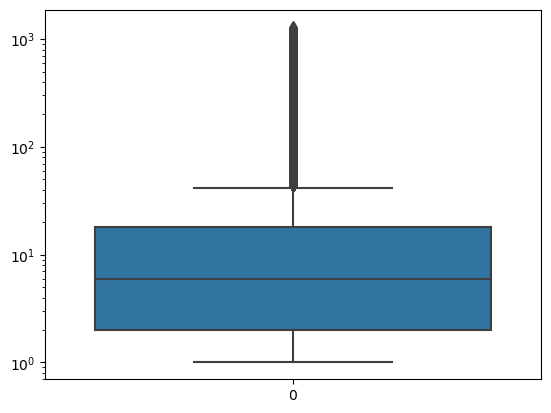

In [237]:
h = sns.boxplot(n_events_per_user)
h.set_yscale('log')
h

## Number of interactions per item

In [238]:
n_events_per_item.describe()

count    185395.000000
mean        353.311583
std         624.774896
min           1.000000
25%           3.000000
50%         137.000000
75%         428.000000
max       15480.000000
dtype: float64

<Axes: ylabel='Proportion'>

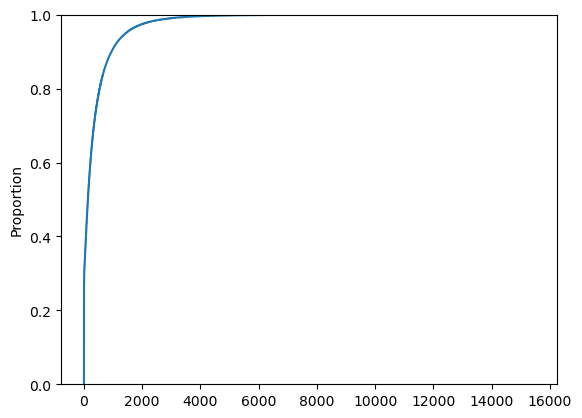

In [239]:
sns.ecdfplot(n_events_per_item)

<Axes: ylabel='Count'>

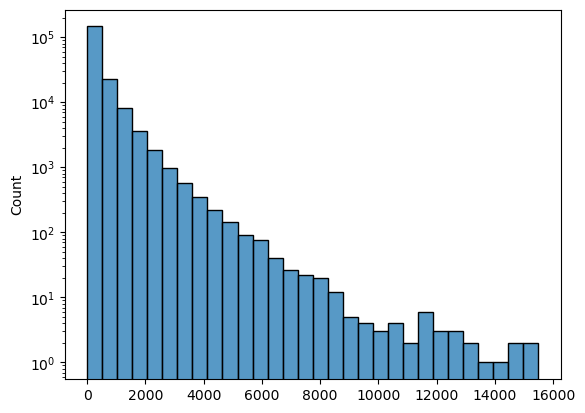

In [240]:
h2 = sns.histplot(n_events_per_item, bins=30)
h2.set_yscale("log")
h2

<Axes: >

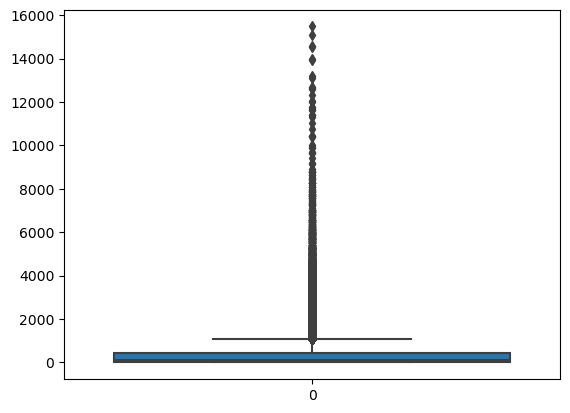

In [241]:
sns.boxplot(n_events_per_item)

<Axes: >

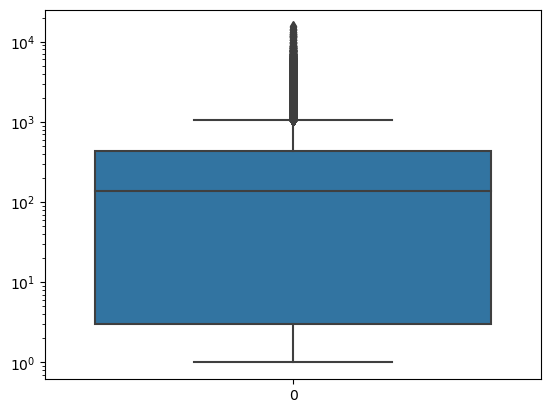

In [242]:
h4 = sns.boxplot(n_events_per_item)
h4.set_yscale('log')
h4

In [243]:
n_events_per_item = df['item'].value_counts()
n_events_per_item

item
145769    15480
171495    15092
44153     14581
41518     14544
179685    13985
          ...  
118231        1
48346         1
85236         1
138689        1
81245         1
Name: count, Length: 185395, dtype: int64

In [244]:
# prop = int(np.floor(n_items*0.1))
prop=100
top_items = n_events_per_item.head(prop)

In [245]:
top_items.sort_values()

item
44689      6979
47799      6990
52647      7004
97375      7015
21203      7034
          ...  
179685    13985
41518     14544
44153     14581
171495    15092
145769    15480
Name: count, Length: 100, dtype: int64

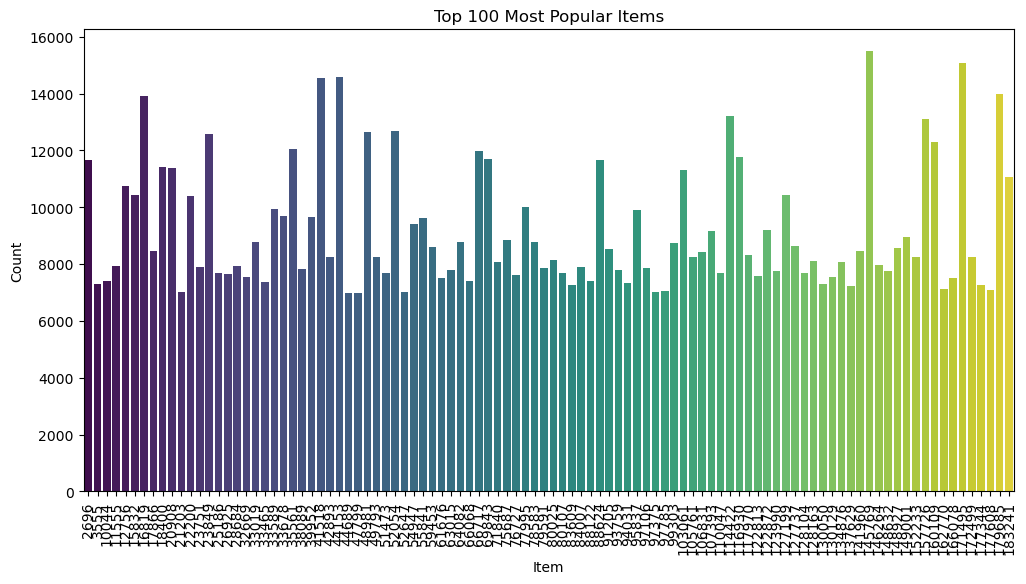

In [246]:
# Create a DataFrame with the selected top items and their counts
top_items_df = pd.DataFrame({'item': top_items.index, 'count': top_items.values})

# Create a Seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='item', y='count', data=top_items_df, palette='viridis')
plt.xticks(rotation=90)
plt.title(f'Top {prop} Most Popular Items')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

## Wstępna obróbka danych

Podział wartości z kolumny `event` tak aby móc dostosować naszą ramkę danych do zadania. 

In [247]:
rating = {
    'click': 1,
    'bookmark': 2,
    'chat_click': 3,
    'contact_phone_click_1': 3,
    'contact_partner_click': 3,
    'contact_phone_click_2': 3,
    'contact_phone_click_3': 3,
    'contact_chat': 3
}
df['event'] = df['event'].map(rating)
df = df.rename(columns={'event': 'label'})
df = df.rename(columns={'timestamp': 'time'})

Ustawiamy liczbę interakcji użytkowników od największej do najmniejszej i sprawdzamy jak wyglądają te liczby.

In [248]:
user_interaction_counts = df['user'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_users = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_users.head())

user
750207     1310
2358298    1308
3057718    1308
88606      1307
2016978    1303
Name: count, dtype: int64


Pozbywamy się użytkowników z liczbą interakcji mniejszą niż 100. Mamy nadzieje odsiać w ten sposób użytkowników, którzy nie są regularnymi użytkownikami.

In [249]:
reg_users = user_interaction_counts[user_interaction_counts >= 100]

Pozbywamy się outlierów korzystając z metody 8 sigm.

In [250]:
users_to_keep = reg_users[reg_users <= reg_users.mean() + 8*reg_users.std()].index
df = df[df['user'].isin(users_to_keep)]

In [251]:
n_events_per_user = df.groupby('user').size()
# n_events_per_user = n_events_per_user.to_frame()
print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
n_events_per_user.describe()

Average number of events per user:  202.48  with a standard deviation of  134.87381371148234
Median number of events per user:  156.0


count    123531.000000
mean        202.475403
std         134.874360
min         100.000000
25%         121.000000
50%         156.000000
75%         229.000000
max        1283.000000
dtype: float64

<Axes: ylabel='Proportion'>

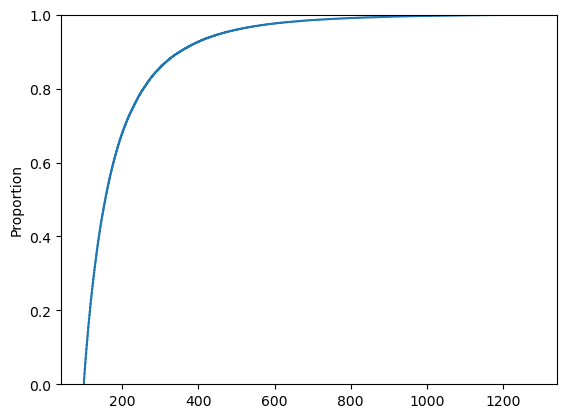

In [252]:
sns.ecdfplot(n_events_per_user)

<Axes: ylabel='Count'>

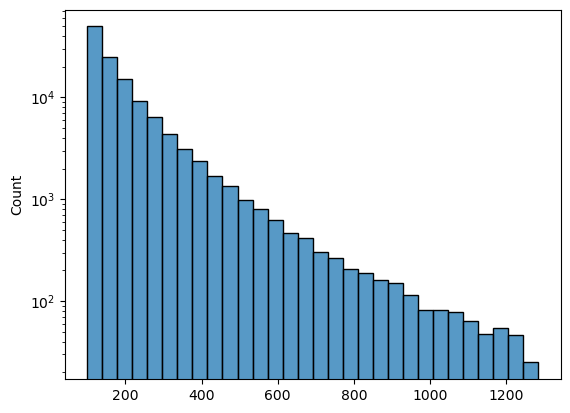

In [253]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1

{'whiskers': [<matplotlib.lines.Line2D at 0x1cad2812ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cad282c450>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cae73e0b10>],
 'medians': [<matplotlib.lines.Line2D at 0x1cad282db90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cad282e610>],
 'means': []}

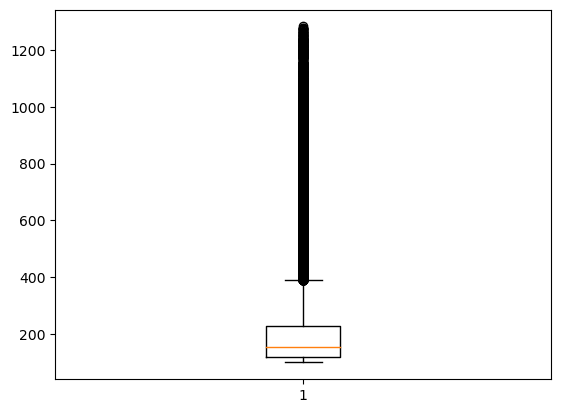

In [254]:
plt.boxplot(n_events_per_user)

AttributeError: 'dict' object has no attribute 'set_yscale'

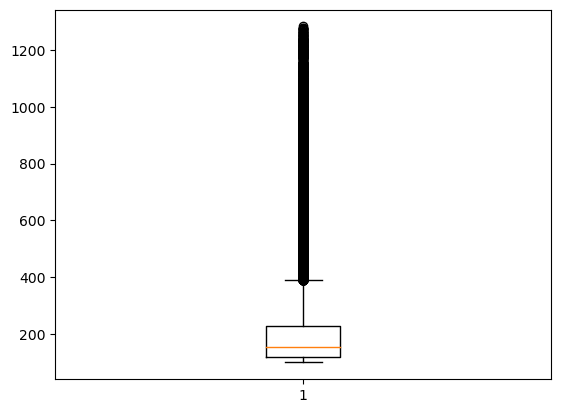

In [257]:
h = plt.boxplot(n_events_per_user)
h.set_yscale('log')
h

In [258]:
items_interaction_counts = df['item'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_items = items_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_items.head())

item
44153     7276
52054     7080
179685    6961
66717     6957
16819     6909
Name: count, dtype: int64


Pozbywamy się przedmiotów o mniejszej liczbie interakcji niż 1000. Mamy nadzieje, by w ten sposób, zachować przedmioty, które cieszą się przynajmniej umiarkowanym sukcesem.

In [259]:
popular_items = items_interaction_counts[items_interaction_counts >= 1000]

Pozbywamy się outlierów korzystając z metody 9 sigm.

In [260]:
items_to_keep = popular_items[popular_items <= popular_items.mean() + 9*popular_items.std()].index
df = df[df['item'].isin(items_to_keep)]

In [261]:
n_events_per_item = df.groupby('item').size()
# n_events_per_item = n_events_per_item.to_frame()
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))
n_events_per_item.describe()

Average number of events per item:  1579.65  with a standard deviation of  700.3250684599021
Median number of events per item:  1355.0


count    3291.000000
mean     1579.654512
std       700.431493
min      1000.000000
25%      1139.000000
50%      1355.000000
75%      1754.500000
max      7276.000000
dtype: float64

<Axes: ylabel='Proportion'>

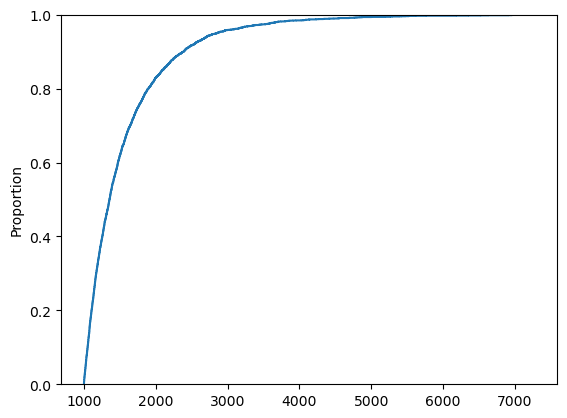

In [262]:
sns.ecdfplot(n_events_per_item)

<Axes: ylabel='Count'>

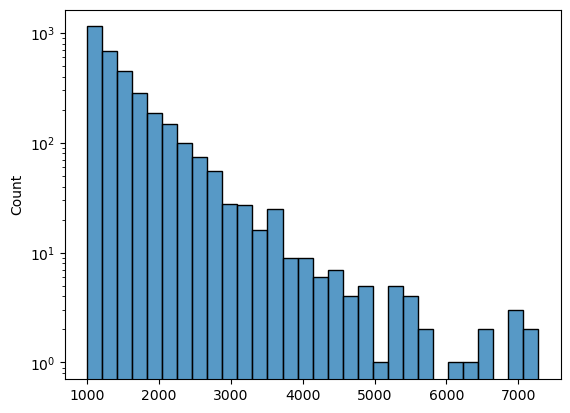

In [263]:
h2 = sns.histplot(n_events_per_item, bins=30)
h2.set_yscale("log")
h2

{'whiskers': [<matplotlib.lines.Line2D at 0x1cad28c7e90>,
 'caps': [<matplotlib.lines.Line2D at 0x1cad27f3d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cad286a810>],
 'medians': [<matplotlib.lines.Line2D at 0x1cad2a336d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cad2a30c10>],
 'means': []}

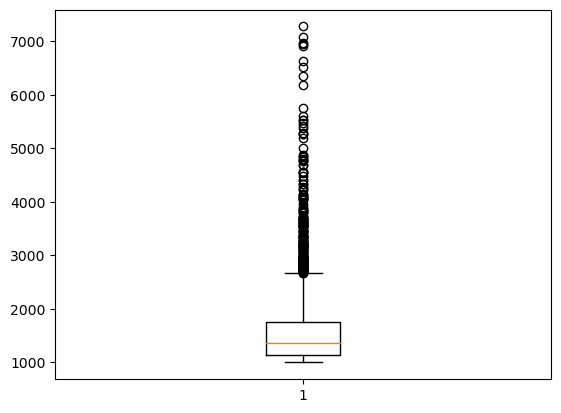

In [264]:
plt.boxplot(n_events_per_item)

AttributeError: 'dict' object has no attribute 'set_yscale'

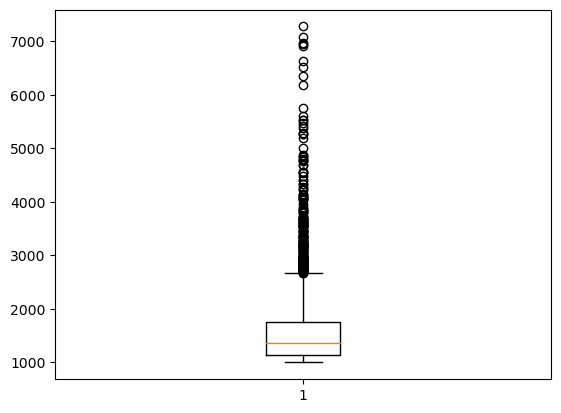

In [265]:
h4 = plt.boxplot(n_events_per_item)
h4.set_yscale('log')
h4

In [266]:
# prop = int(np.floor(n_items*0.1))
prop=100
top_items = n_events_per_item.head(prop)
top_items.sort_values()

item
2886    1004
1153    1010
4818    1012
5372    1022
4655    1029
        ... 
5572    2782
5479    2784
872     3156
1897    3289
2696    4028
Length: 100, dtype: int64

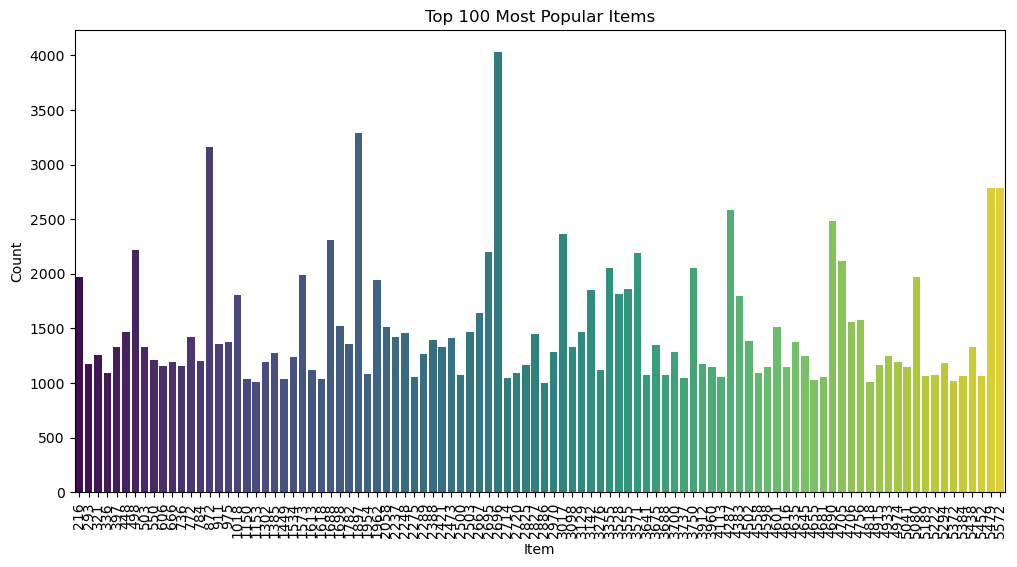

In [267]:
# Create a DataFrame with the selected top items and their counts
top_items_df = pd.DataFrame({'item': top_items.index, 'count': top_items.values})

# Create a Seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='item', y='count', data=top_items_df, palette='viridis')
plt.xticks(rotation=90)
plt.title(f'Top {prop} Most Popular Items')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

Dla tej kombinacji sigm zaobserwowałem najwyższe gęstość danych.

Pierwsza filtracja ramki danych. Wybieramy 20% przedmiotów o największej liczbie interakcji.

In [268]:
# Obliczenie liczby interakcji dla każdego przedmiotu
item_interaction_counts = df['item'].value_counts()

# Obliczenie kwantyla dla top 20% przedmiotów
top_20_threshold = item_interaction_counts.quantile(0.8)

# Wybór przedmiotów, które są w top 20% o największej liczbie interakcji
top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

# Przefiltrowanie ramki danych, aby pozostawić tylko wybrane przedmioty
filtered_df = df[df['item'].isin(top_20_items)]

In [269]:
item_interaction_counts = filtered_df['item'].value_counts()

# Sortowanie przedmiotow według liczby interakcji od największej do najmniejszej
sorted_items = item_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych przedmiotów
print(sorted_items.head())

item
44153     7276
52054     7080
179685    6961
66717     6957
16819     6909
Name: count, dtype: int64


To samo robimy dla 20% użytkowników o największej liczbie interakcji.

In [270]:
user_interaction_counts = filtered_df['user'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_users = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_users.head())

user
1288580    1054
1948352     537
2090363     484
3049290     468
239584      396
Name: count, dtype: int64


In [271]:
# Obliczenie liczby interakcji dla każdego użytkownika
user_interaction_counts = df['user'].value_counts()

# Obliczenie kwantyla dla top 20% użytkowników
top_20_threshold = user_interaction_counts.quantile(0.8)

# Wybór użytkowników, którzy są w top 20% o największej liczbie interakcji
top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

# Przefiltrowanie ramki danych, aby pozostawić tylko wybranych użytkowników
filtered_df = filtered_df[filtered_df['user'].isin(top_20_users)]

In [272]:
item_interaction_counts = filtered_df['item'].value_counts()

# Sortowanie przedmiotów według liczby interakcji od największej do najmniejszej
sorted_items = item_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych przedmiotów
print(sorted_items.head())

user_interaction_counts = filtered_df['user'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_userss = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_users.head())

item
66717     5250
44153     5098
16819     5049
171495    4957
179685    4912
Name: count, dtype: int64
user
1288580    1054
1948352     537
2090363     484
3049290     468
239584      396
Name: count, dtype: int64


Porównujemy proporcję przedmioty / użytkownicy w wejściowej ramce danych oraz przefiltrowanej. Jak widzimy, proporcja ta jest prawie identyczna.

In [273]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df['user'].nunique()
print(count_users)
count_items = filtered_df['item'].nunique()
print(count_items)
print(count_items/count_users * 100)
count_items_before/count_users_before * 100

25060
659
2.6296887470071826


2.6695544253279144

Kolejna filtracja ramki danych. Teraz losowo wybieramy 20% unikatowych przedmiotów i użytkowników tak, aby maszyny, na których pracujemy nie miały problemów z pamięcią.

In [274]:
# Procent użytkowników i przedmiotów do wyboru
sample_percent = 1

# Wybór x% unikatowych użytkowników
sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent, random_state=2024)

# Wybór x% unikatowych przedmiotów
sampled_items = filtered_df.drop_duplicates('item').sample(frac=sample_percent, random_state=2024)

# Przefiltrowanie przefiltrowanej ramki danych, aby pozostawić tylko wybrane użytkowniki
filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

# Przefiltrowanie wynikowej ramki danych, aby pozostawić tylko wybrane przedmioty
filtered_df = filtered_df_users[filtered_df_users['item'].isin(sampled_items['item'])]

Znów sprawdzmy proporcję przedmioty / użytkownicy. 

In [275]:
count_users = filtered_df['user'].nunique()
print(count_users)
count_items = filtered_df['item'].nunique()
print(count_items)
print(count_items/count_users * 100)
count_items_before/count_users_before * 100

25060
659
2.6296887470071826


2.6695544253279144

In [276]:
user_interaction_counts = filtered_df['user'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_users = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_users.head())

user
1288580    1054
1948352     537
2090363     484
3049290     468
239584      396
Name: count, dtype: int64


In [277]:
# # user_interaction_counts = df['user'].value_counts()
# # item_interaction_counts = df['item'].value_counts()

# # # Wybór 20% użytkowników o największej liczbie interakcji
# # top_users = user_interaction_counts.head(int(len(user_interaction_counts) * 0.2))

# # # Wybór 20% przedmiotów o największej liczbie interakcji
# # top_items = item_interaction_counts.head(int(len(item_interaction_counts) * 0.2))

# # Wybór x% użytkowników i przedmiotów do próbkowania
# sample_percent = 0.2  # Możesz zmieniać ten procent w zakresie od 0.01 do 0.5

# # Konwertowanie indeksu na ramkę danych dla użytkowników i przedmiotów
# top_users_df = top_users.reset_index()
# top_users_df.columns = ['user', 'interactions']
# top_items_df = top_items.reset_index()
# top_items_df.columns = ['item', 'interactions']

# # Wybór x% użytkowników
# sampled_users = filtered_df.sample(frac=sample_percent, random_state=42)

# # Wybór x% przedmiotów
# sampled_items = filtered_df.sample(frac=sample_percent, random_state=42)

# # Wyświetlenie wybranych użytkowników i przedmiotów
# print("Wybrane użytkownicy:")
# print(sampled_users.head())
# print("\nWybrane przedmioty:")
# print(sampled_items.head())

In [278]:
# filtered_df = df[df['user'].isin(sampled_users['user']) & df['item'].isin(sampled_items['item'])]

# # Wyświetlenie przefiltrowanej ramki danych
# print(filtered_df.head())

In [279]:
# user_interaction_counts = df.groupby('user')['label'].count()
# item_interaction_counts = df.groupby('item')['label'].count()
# user_mean = user_interaction_counts.mean()
# user_std = user_interaction_counts.std()
# item_mean = item_interaction_counts.mean()
# item_std = item_interaction_counts.std()

# # Ustalenie granicy dla wartości odstających (trzy odchylenia standardowe od średniej)
# user_outlier_threshold = user_mean + 3 * user_std
# item_outlier_threshold = item_mean + 3 * item_std

# # Odrzucenie outlierów dla użytkowników
# users_no_outliers = df.groupby('user').filter(lambda x: x['label'].count() < user_outlier_threshold)

# # Odrzucenie outlierów dla przedmiotów
# items_no_outliers = df.groupby('item').filter(lambda x: x['label'].count() < item_outlier_threshold)

# # Ograniczenie ramki danych do użytkowników i przedmiotów bez outlierów
# df_no_outliers = df[df['user'].isin(users_no_outliers['user'].unique()) & df['item'].isin(items_no_outliers['item'].unique())]

In [280]:
# count_users_before = df['user'].nunique()
# count_items_before = df['item'].nunique()
# count_users = df_no_outliers['user'].nunique()
# print(count_users)
# count_items = df_no_outliers['item'].nunique()
# print(count_items)
# print(count_items/count_users * 100)
# count_items_before/count_users_before * 100

In [281]:
# user_interaction_counts = df_no_outliers.groupby('user')['label'].count()
# item_interaction_counts = df_no_outliers.groupby('item')['label'].count()

# # Obliczenie liczby unikalnych wartości, które chcemy zachować
# n_unique_values_to_keep = int(len(item_interaction_counts) * 0.2)

# # Wybieranie 20% najczęściej występujących unikalnych wartości 'item'
# most_common_values = item_interaction_counts.head(n_unique_values_to_keep).index.tolist()

# # Ograniczenie ramki danych do wierszy zawierających te wartości
# filtered_df = df_no_outliers[df_no_outliers['item'].isin(most_common_values)]

# n_unique_values_to_keep_user = int(len(user_interaction_counts) * 0.2)

# # Wybieranie 20% najczęściej występujących unikalnych wartości 'item'
# most_common_values = user_interaction_counts.head(n_unique_values_to_keep_user).index.tolist()

# # Ograniczenie ramki danych do wierszy zawierających te wartości
# filtered_df = filtered_df[filtered_df['user'].isin(most_common_values)]

In [282]:
# count_users = filtered_df['user'].nunique()
# print(count_users)
# count_items = filtered_df['item'].nunique()
# print(count_items)
# print(count_items/count_users * 100)
# count_items_before/count_users_before * 100

In [283]:
# grouped = filtered_df.groupby(['user', 'item'])['label'].nunique()

# # Znajdowanie indeksów wierszy, które spełniają warunek (tylko jedna unikalna wartość 'event')
# rows_to_drop = grouped[grouped == 1].index

# # Usuwanie wierszy, które spełniają warunek
# filtered_df = filtered_df[~filtered_df.set_index(['user', 'item']).index.isin(rows_to_drop)]

## Podział przefiltrowanej ramki danych na zbiór treningowy i testowy

In [284]:
# distinct_users = filtered_df['user'].unique()

# num_users_group1 = int(0.7 * distinct_users.shape[0])  # 7%
# num_users_group2 = int(0.3 * distinct_users.shape[0])  # 3%

# group1_users = random.sample(list(distinct_users), num_users_group1)
# remaining_users = list(set(distinct_users) - set(group1_users))
# group2_users = random.sample(remaining_users, num_users_group2)
# #group3_users = list(set(remaining_users) - set(group2_users))

# group1_df = filtered_df[filtered_df['user'].isin(group1_users)]
# group2_df = filtered_df[filtered_df['user'].isin(group2_users)]
# #group3_df = filtered_df[filtered_df['user'].isin(group3_users)]

In [285]:
# # Obliczenie liczby interakcji dla każdego przedmiotu
# item_interaction_counts = group1_df['item'].value_counts()

# # Obliczenie kwantyla dla top 20% przedmiotów
# top_20_threshold = item_interaction_counts.quantile(0.8)

# # Wybór przedmiotów, które są w top 20% o największej liczbie interakcji
# top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

# # Przefiltrowanie oryginalnej ramki danych, aby pozostawić tylko wybranych użytkowników
# group1_df = group1_df[group1_df['item'].isin(top_20_items)]

In [286]:
# unique_users_count = group1_df['user'].nunique()
# unique_items_count = group1_df['item'].nunique()

# Wybór x% unikatowych użytkowników
#sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent, random_state=2024)

# # Wybór x% unikatowych przedmiotów
# sampled_items = group1_df.drop_duplicates('item').sample(frac=0.2, random_state=2024)

# Przefiltrowanie przefiltrowanej ramki danych, aby pozostawić tylko wybrane użytkowniki
#filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

# # Przefiltrowanie wynikowej ramki danych, aby pozostawić tylko wybrane przedmioty
# group1_df = group1_df[group1_df['item'].isin(sampled_items['item'])]

# user_interaction_counts = group1_df.groupby('user')['label'].count()
# item_interaction_counts = group1_df.groupby('item')['label'].count()

# # Obliczenie liczby unikalnych wartości, które chcemy zachować
# n_unique_values_to_keep = int(len(item_interaction_counts) * 0.2)

# # Wybieranie 20% najczęściej występujących unikalnych wartości 'item'
# most_common_values = item_interaction_counts.head(n_unique_values_to_keep).index.tolist()

# # Ograniczenie ramki danych do wierszy zawierających te wartości
# filtered_g1 = group1_df[group1_df['item'].isin(most_common_values)]

# n_unique_values_to_keep_user = int(len(user_interaction_counts) * 0.8)

# # Wybieranie 20% najczęściej występujących unikalnych wartości 'item'
# most_common_values = user_interaction_counts.head(n_unique_values_to_keep_user).index.tolist()

# # Ograniczenie ramki danych do wierszy zawierających te wartości
# filtered_g1 = filtered_g1[filtered_g1['user'].isin(most_common_values)]

In [287]:
# count_users = group1_df['user'].nunique()
# print(count_users)
# count_items = group1_df['item'].nunique()
# print(count_items)
# print(count_items/count_users * 100)
# count_items_before/count_users_before * 100

In [288]:
# user_interaction_counts = group1_df['user'].value_counts()

# # Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
# sorted_users = user_interaction_counts.sort_values(ascending=False)

# # Wyświetlenie posortowanych użytkowników
# print(sorted_users.head())

In [289]:
# def split_data_by_user_quantile(df, quant):
# #     # Group the data by user
#      grouped = df.groupby('user')

# #     # Initialize empty lists to store data below and above quantile threshold for each user
#      below_quantile_list = []
#      above_quantile_list = []

# #     # Iterate over each user group
#      for user, group_data in grouped:
#          # Calculate the 70th quantile of the timestamp column for the current user
#          quantile_user = group_data['time'].quantile(quant)

# #         # Split the data for the current user into two sets based on the quantile threshold
#          below_quantile = group_data[group_data['time'] <= quantile_user]
#          above_quantile = group_data[group_data['time'] > quantile_user]

# #         # Append the sets to the respective lists
#          below_quantile_list.append(below_quantile)
#          above_quantile_list.append(above_quantile)

# #     # Concatenate the sets for all users into DataFrames
#      below_quantile_df = pd.concat(below_quantile_list)
#      above_quantile_df = pd.concat(above_quantile_list)

#      return below_quantile_df, above_quantile_df

# # # Split data for each group based on user-specific quantile threshold
# group1_below_user_quantile, group1_above_user_quantile = split_data_by_user_quantile(filtered_g1, 0.7)
# # group2_below_user_quantile, group2_above_user_quantile = split_data_by_user_quantile(group2_df, 0.7)

# # # Display the shapes of the resulting sets
# print("Group 1 - Below or equal  70th user-specific quantile:", group1_below_user_quantile.shape)
# print("Group 1 - Above to 70th user-specific quantile:", group1_above_user_quantile.shape)
# #print("Group 2 - Below or equal 70th user-specific quantile:", group2_below_user_quantile.shape)
# #print("Group 2 - Above to 70th user-specific quantile:", group2_above_user_quantile.shape)

In [290]:
# print(group1_below_user_quantile['item'].nunique())
# group1_above_user_quantile['item'].nunique()

In [291]:
# unique_items_b = set(group1_below_user_quantile['item'].unique())
# unique_items_a = set(group1_above_user_quantile['item'].unique())

# unique_items_only_in_a = unique_items_a.difference(unique_items_b)
# unique_items_only_in_b = unique_items_b.difference(unique_items_a)

# print(len(unique_items_only_in_a))
# print(len(unique_items_only_in_b))

Implementujemy kod z biblioteki LibRecommender dzielący dane na zbiór treningowy i ewaluacyjny.

In [292]:
# train_data = group1_below_user_quantile
# eval_data = group1_above_user_quantile
train_data, eval_data = split_by_ratio_chrono(filtered_df,test_size=0.5)
# train_data, eval_data = split_by_ratio_chrono(group1_df,test_size=0.2)
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
#test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 25060, n_items: 659, data density: 3.1284 %


In [293]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

In [294]:
%%time
# można też spróbować %%timeit jeśli kod się będzie w miarę krótko wykonywał (liczy średnii czas wykonywania komórki) 
lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-06 12:30:17


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:08<00:00,  3.69it/s]


Epoch 1 elapsed: 68.487s
	 train_loss: 0.1882


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 379.31it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1519.87it/s]


	 eval log_loss: 0.5561
	 eval precision@10: 0.1597
	 eval recall@10: 0.1572
	 eval ndcg@10: 0.4568
	 eval map@10: 0.3408


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:08<00:00,  3.70it/s]


Epoch 2 elapsed: 68.349s
	 train_loss: 0.1073


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 373.52it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1639.40it/s]


	 eval log_loss: 0.6056
	 eval precision@10: 0.1715
	 eval recall@10: 0.1703
	 eval ndcg@10: 0.4803
	 eval map@10: 0.3610


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:06<00:00,  3.79it/s]


Epoch 3 elapsed: 66.809s
	 train_loss: 0.0892


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 375.37it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1646.83it/s]


	 eval log_loss: 0.6419
	 eval precision@10: 0.1777
	 eval recall@10: 0.1768
	 eval ndcg@10: 0.4921
	 eval map@10: 0.3712


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:06<00:00,  3.83it/s]


Epoch 4 elapsed: 66.049s
	 train_loss: 0.0787


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 368.09it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1569.85it/s]


	 eval log_loss: 0.6743
	 eval precision@10: 0.1796
	 eval recall@10: 0.1791
	 eval ndcg@10: 0.4958
	 eval map@10: 0.3743


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:07<00:00,  3.77it/s]


Epoch 5 elapsed: 67.085s
	 train_loss: 0.071


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 359.98it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1560.58it/s]


	 eval log_loss: 0.7066
	 eval precision@10: 0.1818
	 eval recall@10: 0.1812
	 eval ndcg@10: 0.5017
	 eval map@10: 0.3794
CPU times: total: 19min 26s
Wall time: 5min 56s


In [295]:
%%time
lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-06 12:36:14


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:08<00:00,  3.70it/s]


Epoch 1 elapsed: 68.472s
	 train_loss: 0.0589


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 378.58it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1544.98it/s]


	 eval log_loss: 0.7261
	 eval precision@10: 0.1814
	 eval recall@10: 0.1811
	 eval ndcg@10: 0.5023
	 eval map@10: 0.3804


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:05<00:00,  3.86it/s]


Epoch 2 elapsed: 65.590s
	 train_loss: 0.0506


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 374.24it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1693.22it/s]


	 eval log_loss: 0.7427
	 eval precision@10: 0.1802
	 eval recall@10: 0.1802
	 eval ndcg@10: 0.5010
	 eval map@10: 0.3792


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:05<00:00,  3.89it/s]


Epoch 3 elapsed: 65.111s
	 train_loss: 0.0449


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 363.77it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1665.94it/s]


	 eval log_loss: 0.7649
	 eval precision@10: 0.1795
	 eval recall@10: 0.1793
	 eval ndcg@10: 0.5003
	 eval map@10: 0.3790


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:05<00:00,  3.87it/s]


Epoch 4 elapsed: 65.320s
	 train_loss: 0.041


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 376.79it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1659.66it/s]


	 eval log_loss: 0.7870
	 eval precision@10: 0.1775
	 eval recall@10: 0.1774
	 eval ndcg@10: 0.4980
	 eval map@10: 0.3769


train: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [01:04<00:00,  3.90it/s]


Epoch 5 elapsed: 64.812s
	 train_loss: 0.0372


eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 380.70it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1624.34it/s]


	 eval log_loss: 0.8097
	 eval precision@10: 0.1767
	 eval recall@10: 0.1768
	 eval ndcg@10: 0.4984
	 eval map@10: 0.3779
CPU times: total: 19min 40s
Wall time: 5min 46s


In [299]:
evaluate(
    model=lightgcn,
    data=eval_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 365.20it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1635.26it/s]


{'loss': 0.9084488632047548,
 'precision': 0.1710937186433875,
 'recall': 0.1718696947937149,
 'ndcg': 0.4906803537645628,
 'map': 0.3713657159308174}

In [300]:
evaluate(
    model=lightgcn,
    data=eval_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=5
)

eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 392.71it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1581.31it/s]


{'loss': 0.9084488632047548,
 'precision': 0.2061489062813566,
 'recall': 0.10925610344535248,
 'ndcg': 0.4509464638852109,
 'map': 0.3805502632900866}

In [302]:
evaluate(
    model=lightgcn,
    data=eval_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=2
)

eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 398.68it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1662.81it/s]


{'loss': 0.9084488632047548,
 'precision': 0.24224362833634358,
 'recall': 0.054460815801833706,
 'ndcg': 0.35600566991184746,
 'map': 0.33672486453943407}

In [301]:
evaluate(
    model=lightgcn,
    data=eval_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=1
)

eval_pointwise: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 388.15it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2077/2077 [00:01<00:00, 1789.20it/s]


{'loss': 0.9084488632047548,
 'precision': 0.2630945213726671,
 'recall': 0.03018544044546011,
 'ndcg': 0.2630945213726671,
 'map': 0.2630945213726671}

Wszystko poniżej tego kawałka kodu to zabawy w zmianę funkcji straty, zmiana parametrów itd itp.

In [567]:
HAMUJ SIĘ

SyntaxError: invalid syntax (233987486.py, line 1)

In [ ]:
# evaluate(
#     model=lightgcn,
#     data=group2_df,
#     neg_sampling=True,
#     metrics=["loss", "precision", "recall", "ndcg", "map"],
#     k=10
# )

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=32,
    n_epochs=5,
    lr=0.001,
    batch_size=512,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="focal",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="max_margin",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)